In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN 

import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)

<module 'RSI' from 'C:\\Users\\jpran\\Capstone\\RSI.py'>

In [2]:
name = 'NVDA' 
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=False)

In [3]:
ori_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

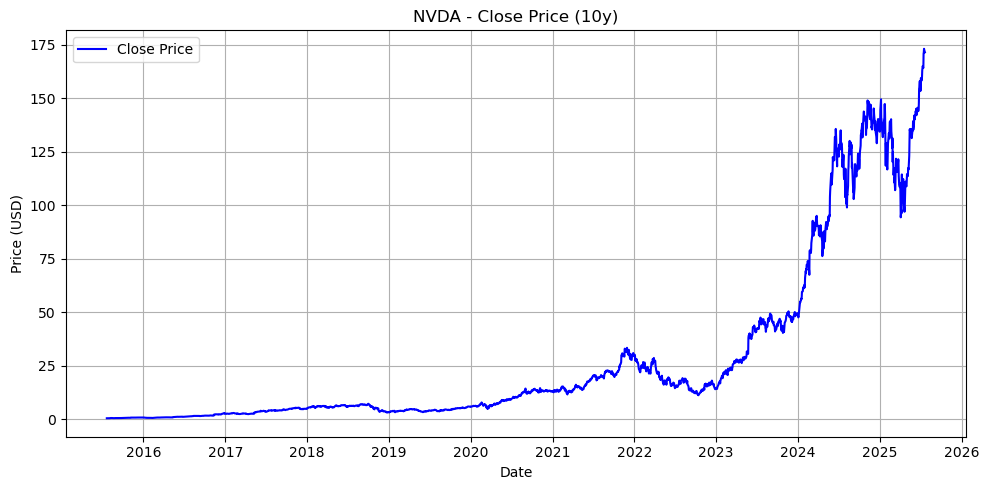

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
df = ori_df.copy()

In [6]:
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close',P=0.09, T=5)

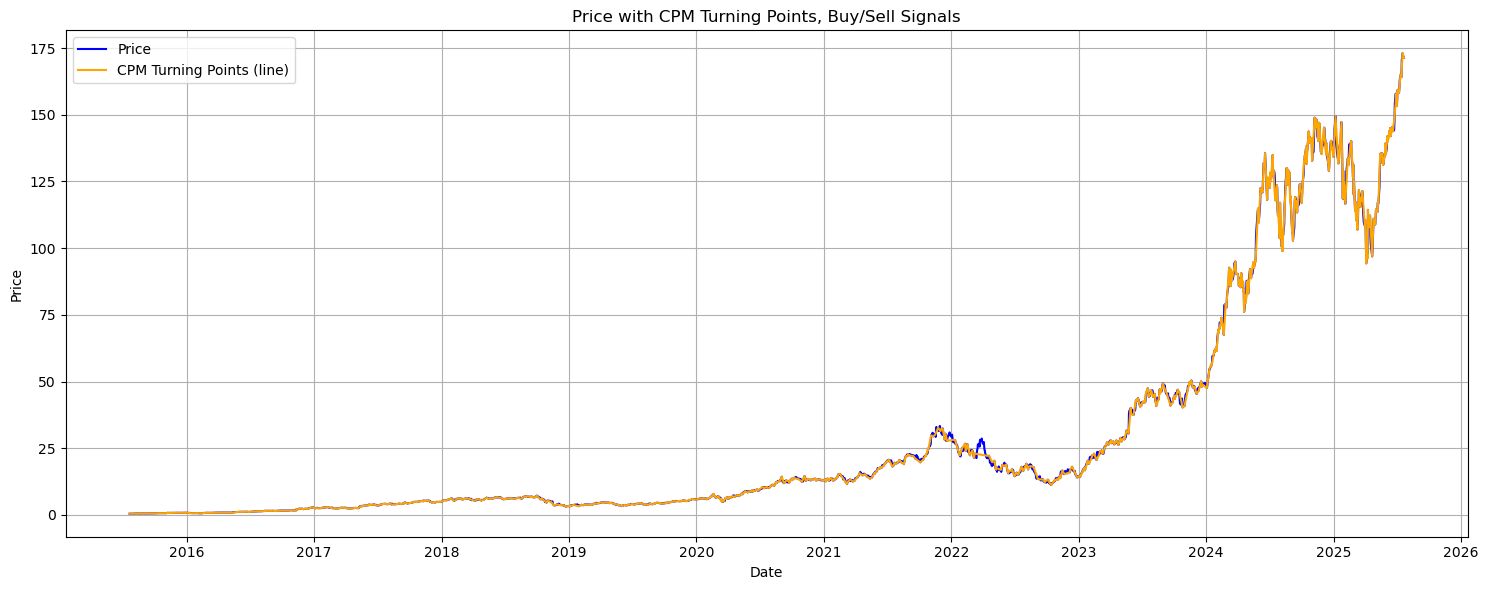

In [7]:
# CPM 신호가 있는 인덱스와 가격
cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

# Buy (1) / Sell (-1) 인덱스와 가격
buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
buy_prices = df_with_cpm.loc[buy_indices, 'Close']
sell_prices = df_with_cpm.loc[sell_indices, 'Close']

plt.figure(figsize=(15, 6))

# 1. 전체 가격 라인
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')

# 2. CPM 전환점을 선으로 연결
plt.plot(cpm_indices, cpm_prices, label='CPM Turning Points (line)', color='orange')

# 3. Buy 시점 (▲ 초록색)
#plt.scatter(buy_indices, buy_prices, label='Buy Signal', marker='^', color='green', s=100)

# 4. Sell 시점 (▼ 빨간색)
#plt.scatter(sell_indices, sell_prices, label='Sell Signal', marker='v', color='red', s=100)

plt.title("Price with CPM Turning Points, Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()

In [9]:
total_len = len(df)

train_end = int(total_len * 0.8)
train_df = df_with_cpm.iloc[:train_end]
test_df = df_with_cpm.iloc[train_end:]

In [10]:
ma_best_params, ma_best_fitness, train_df = ma.run_MA_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

이동평균 유전 알고리즘 실행 중...
gen	nevals	avg    	min    	max    
0  	50    	213.503	207.916	224.843
1  	39    	inf    	207.51 	inf    
2  	39    	inf    	207.143	inf    
3  	39    	211.805	207.167	222.831
4  	41    	inf    	209.099	inf    
5  	42    	inf    	208.95 	inf    
6  	38    	inf    	208.124	inf    
7  	29    	210.777	208.684	222.114
8  	44    	211.399	207.403	219.984
9  	37    	210.489	207.479	223.931
10 	37    	209.826	207.182	213.802
11 	39    	209.576	207.314	212.664
12 	40    	209.579	207.903	212.466
13 	35    	208.797	207.903	211.153
14 	41    	208.503	207.903	210.209
15 	45    	208.39 	207.903	210.02 
16 	35    	208.405	207.903	210.667
17 	33    	208.202	207.28 	209.877
18 	33    	208.146	207.28 	209.878
19 	43    	208.294	207.28 	211.13 
20 	36    	208.179	207.28 	210.449
21 	43    	208.109	207.28 	210.449
22 	38    	208.182	207.28 	210.449
23 	35    	208.108	207.28 	210.794
24 	32    	208.011	207.28 	210.449
25 	32    	207.959	207.28 	210.449
26 	43    	207.758	207.28 	210.449

In [11]:
N, n, a, b, c = ma_best_params

In [12]:
test_ma_signals = ma.generate_MA_signals(test_df, N, n, a, b, c)

In [13]:
signal_map = test_ma_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_11136\4009268628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['MA_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [14]:
rsi_best_params, rsi_best_fitness, train_df = rsi.run_RSI_ga_optimization(train_df)

print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

RSI 유전 알고리즘 실행 중...
gen	nevals	avg  	min    	max    
0  	50    	211.9	208.924	212.115
1  	40    	inf  	208.924	inf    
2  	30    	inf  	208.697	inf    
3  	40    	inf  	208.399	inf    
4  	32    	inf  	208.891	inf    
5  	33    	inf  	208.891	inf    
6  	33    	inf  	207.483	inf    
7  	42    	inf  	207.483	inf    
8  	34    	inf  	207.483	inf    
9  	30    	inf  	207.483	inf    
10 	36    	inf  	207.483	inf    
11 	34    	inf  	207.291	inf    
12 	39    	209.282	207.483	212.078
13 	35    	inf    	206.509	inf    
14 	34    	inf    	206.509	inf    
15 	38    	inf    	206.509	inf    
16 	41    	inf    	206.441	inf    
17 	34    	inf    	206.5  	inf    
18 	40    	208.785	206.436	212.077
19 	42    	208.513	206.436	212.078
20 	34    	207.965	205.921	212.045
21 	38    	207.847	205.921	212.07 
22 	38    	207.097	205.921	211.393
23 	37    	207.421	205.862	212.077
24 	33    	207.314	205.862	212.018
25 	39    	207.776	205.776	212.045
26 	35    	207.297	205.672	212.045
27 	40    	207.104	205.752

In [15]:
x, overbought_level, oversold_level, p, q = rsi_best_params

In [16]:
test_rsi_signals = rsi.generate_RSI_signals(test_df, x, overbought_level, oversold_level, p, q)

503 3.8663138540545674


In [17]:
signal_map = test_rsi_signals.set_index('Index')['Type'].map({'BUY': -1, 'SELL': 1})
test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)

C:\Users\jpran\AppData\Local\Temp\ipykernel_11136\1229919477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['RSI_Signals'] = signal_map.reindex(test_df.index).fillna(0).astype(int)


In [18]:
Technical_Signals = ['MA_Signals', 'RSI_Signals']

In [19]:
import ESN_GA
from ESN_GA import run_genetic_algorithm, perform_final_backtest, PARAM_RANGES
importlib.reload(ESN_GA)

C:\Users\jpran\AppData\Roaming\Python\Python312\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

<module 'ESN_GA' from 'C:\\Users\\jpran\\Capstone\\ESN_GA.py'>

In [20]:
best_params_ga, ga_log = run_genetic_algorithm(
    train_df_ga=train_df,
    test_df_ga=test_df,
    technical_signals_list=Technical_Signals,
    pop_size=30,
    num_generations=15,
    random_seed=42
)

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

gen	nevals	avg    	std    	min    	max    
0  	30    	51.6489	70.7791	-15.625	262.184


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

1  	25    	65.3144	78.4413	-38.3746	253.528


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

2  	23    	117.37 	92.2925	-4.2407 	253.528


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

3  	28    	111.338	104.054	-50.5849	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

4  	27    	100.985	117.813	-39.4817	306.736


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

5  	19    	131.215	111.612	-0.608767	306.736


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

6  	21    	164.892	125.418	-36.0556 	306.736


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

7  	30    	169.211	139.204	-18.0564 	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

8  	21    	261.144	92.5962	-28.4084 	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

9  	27    	286.018	40.8316	114.325  	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

10 	25    	296.842	5.68434e-14	296.842  	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

11 	20    	279.558	64.7578    	24.5407  	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

12 	23    	282.222	56.9202    	16.5835  	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

13 	22    	285.339	48.8708    	34.6341  	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

14 	25    	287.738	45.0172    	45.779   	296.842


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]

15 	22    	287.22 	50.1504    	17.2951  	296.842

GA 최적화 완료 - 최적 하이퍼파라미터: [811.2403479202959, 1.0911949144027802, 0.3893984235231291, 0.8766991070393412]
GA 최적화 완료 - 최고 Return [%]: 306.7363


In [21]:
print(best_params_ga)

[811.2403479202959, 1.0911949144027802, 0.3893984235231291, 0.8766991070393412]


In [22]:
final_backtest_stats, final_signals = perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_ga,
    technical_signals_list=Technical_Signals,
    random_state=42
)


--- 최적화된 파라미터로 최종 ESN 학습 및 백테스팅 ---
  n_reservoir: 811
  spectral_radius: 1.0912
  sparsity: 0.3894
  signal_threshold: 0.8767


Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2023-07-19 00:00:00
End                       2025-07-21 00:00:00
Duration                    733 days 00:00:00
Exposure Time [%]                    56.26243
Equity Final [$]                  40673.63468
Equity Peak [$]                   41057.57352
Commissions [$]                     323.93422
Return [%]                          306.73635
Buy & Hold Return [%]                264.0419
Return (Ann.) [%]                   101.95852
Volatility (Ann.) [%]               109.89986
CAGR [%]                             61.98594
Sharpe Ratio                          0.92774
Sortino Ratio                         3.05826
Calmar Ratio                          2.76851
Alpha [%]                            47.20759
Beta                                  0.98291
Max. Drawdown [%]                     -36.828
Avg. Drawdown [%]                     -5.8007
Max. Drawdown Duration      170 days 00:00:00
Avg. Drawdown Duration       20 days 00:00:00
# Trades 

In [23]:
def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
    plt.figure(figsize=(16, 8))
    plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

    # ESN 예측 매수 신호 (BUY) 표시
    buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
    plt.scatter(buy_signals.index, buy_signals['Close'],
                marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

    # ESN 예측 매도 신호 (SELL) 표시
    sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
    plt.scatter(sell_signals.index, sell_signals['Close'],
                marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

    # --- CPM Point Type ---
    if 'cpm_point_type' in original_df.columns:
        cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
        cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

        # CPM BUY 포인트
        plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                    marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

        # CPM SELL 포인트
        plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                    marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
    else:
        print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

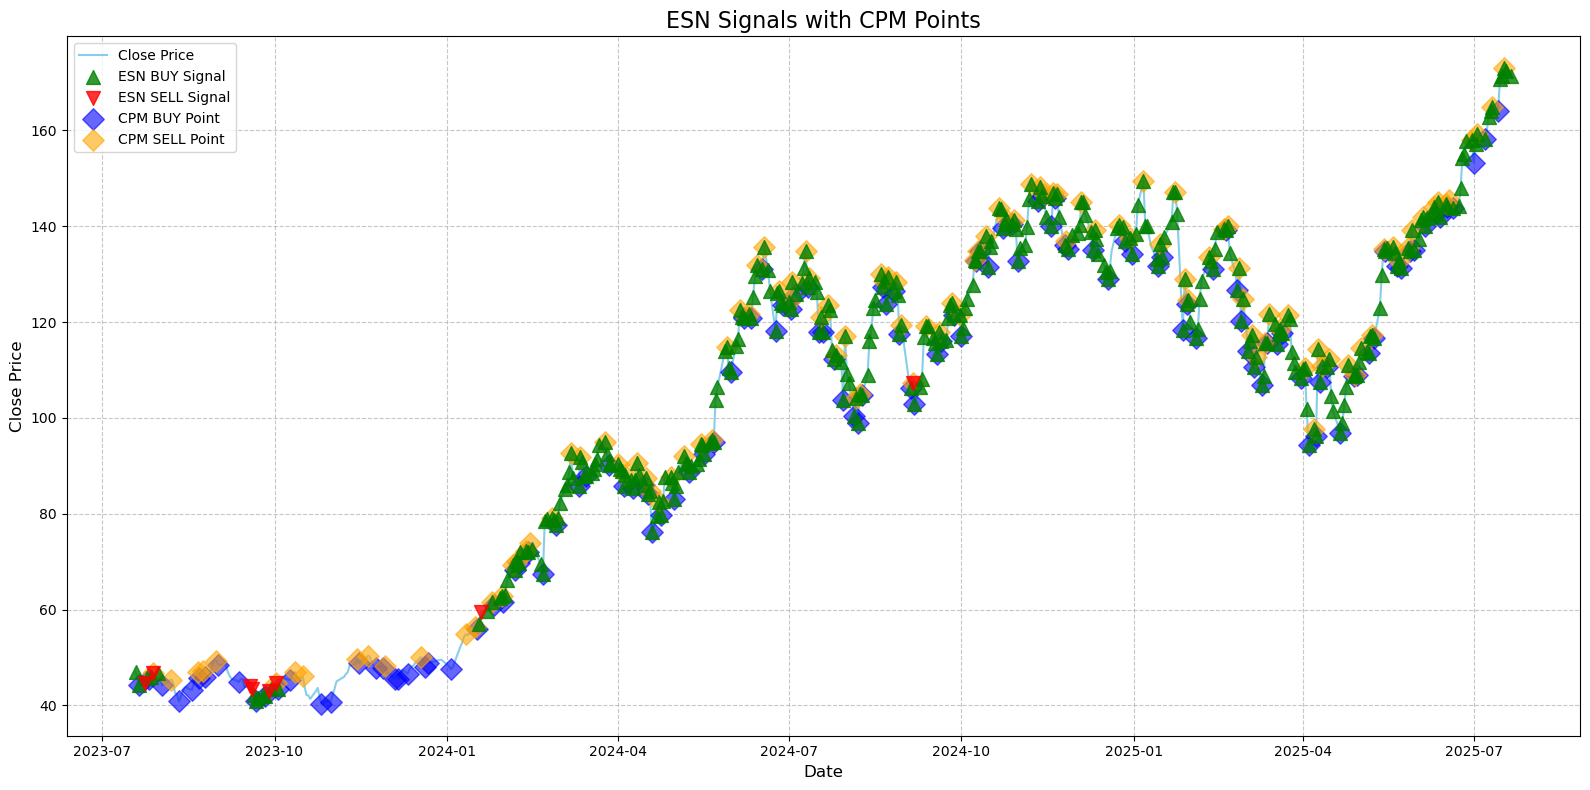

In [24]:
plot_signals(test_df, final_signals)